In [3]:
import numpy as np
from numpy import linalg as la
import pandas as pd
import operator
from math import sqrt
import pandas as pd
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
%matplotlib inline

In [4]:
table = [[2,1,3,1],
         [4,1,3,4],
         [5,5,1,1],
         [2,1,3,2],
         [2,2,3,1]]

user = [2,1,4,0]

In [5]:
#aka strategy pattern implementation
class CosDistance:
    
    def distance(self,vector,vector_to_approx):
        norm_v = la.norm(vector) # if la.norm(vector) > 0 else 1 
        norm_v_approx = la.norm(vector_to_approx) #if la.norm(vector_to_approx) > 0 else 1 
        return np.dot(vector,vector_to_approx)/(norm_v*norm_v_approx)
        
class PirsonDistance:
    
    def distance(self,vector,vector_to_approx):
        vector_mean = np.mean(vector)
        vector_to_approx_mean = np.mean(vector_to_approx)
        a=0
        b=0
        c=0
        for i in range(len(vector_to_approx)):
            vector_diff = (vector[i]-vector_mean)
            vector_ap_diff = (vector_to_approx[i]-vector_to_approx_mean)
            a+= vector_diff*vector_ap_diff
            b+= vector_diff*vector_diff
            c+= vector_ap_diff*vector_ap_diff
        return a/sqrt(b*c)

def sq_score(pred_y,real_y):
    res=[]
    y_v=real_y
    yn_v=pred_y
    for i in range(len(y_v)):
        mod=abs(y_v[i]-yn_v[i])
        maxim=max(y_v[i],yn_v[i])
        r=mod/maxim
        r=pow(mod/maxim,2)
        res.append(1-r)
    return np.array(res).mean()

In [6]:
class UserBasedColaborativeFiltration:
    
    def __init__(self,users,user,distance_calc=None):
        if(distance_calc==None):    
            self.distance_calc = CosDistance()
        else:
              self.distance_calc = distance_calc
        self.user = user
        self.amount_of_closest_users = 3
        self.dataset = users
        self.users = self.most_closest_users(users) 
    
    def most_closest_users(self,users):
        id_value_map = {}
        for i in range(len(users)):
            id_value_map[i]=distance_calc.distance(self.user,users[i])
        sorted_tuples = sorted(id_value_map.items(), key=operator.itemgetter(1),reverse=True)[0:self.amount_of_closest_users]
        return list(map(lambda x: users[x[0]], sorted_tuples))
    
    def predict_mark_on_item(self,item_index):
        user_mean = np.mean(self.user)
        a=0
        b=0
        for us in self.users:
            w=distance_calc.distance(self.user,us)
            a+=w*(us[item_index]-np.mean(us))
            b+=abs(w)
        return user_mean+a/b
    
    #I added this method in order to make def predict_marks() faster because if your movie unknow
    #by clothest users it returns 0 , with the help of this method you don't have to do unnecessary calculations
    def known_by_closest_users(self,index):
        know = 0
        for user in self.users:
            if(user[index]!=0):
                know+=1
        return know>0
    
    #return dictionary type {id_of_item:mark}
    def predict_marks(self):
        marks = {}
        for i,mark in enumerate(self.user):
            if(mark==0 and self.known_by_closest_users(i)):
                marks[i] = int(round(self.predict_mark_on_item(i),0))
        return marks
    
    def accuracy(self):
        R = []
        R_predicted = []
        count = 0
        more_then_max = False
        if(len(self.dataset) >100):
            more_then_max = True
        for user in self.dataset:
            self.users = self.most_closest_users(self.dataset)
            for item in range(len(user)):
                r = user[item]
                if( r != 0 ):
                    R.append(r)
                    R_predicted.append(self.predict_mark_on_item(item))
            count+=1
            if more_then_max and count >100:
                break
        R = list(map(abs,R))
        R_predicted = list(map(abs,R_predicted))
        return (mean_absolute_error(R,R_predicted),mean_squared_error(R,R_predicted),R,R_predicted)
                
            
        
            


In [80]:
distance_calc = CosDistance()
cls = UserBasedColaborativeFiltration(table,user,distance_calc)
marks= cls.predict_marks()
print(marks)
marks= cls.predict_mark_on_item(3)
print(marks)

{3: 1}
1.1538531343882954


In [81]:
print(cls.accuracy())

(0.8815887833877325, 2.127831407514437, [2, 1, 3, 1, 4, 1, 3, 4, 5, 5, 1, 1, 2, 1, 3, 2, 2, 2, 3, 1], [1.8368224332245353, 1.1725019991626342, 2.836822433224535, 1.1538531343882954, 1.8368224332245353, 1.1725019991626342, 2.836822433224535, 1.1538531343882954, 1.8368224332245353, 1.1725019991626342, 2.836822433224535, 1.1538531343882954, 1.8368224332245353, 1.1725019991626342, 2.836822433224535, 1.1538531343882954, 1.8368224332245353, 1.1725019991626342, 2.836822433224535, 1.1538531343882954])


In [82]:
#looks like UserBasedColaborativeFiltration but with transposed data
class ItemBasedColaborativeFiltration:
    
    def __init__(self,users,user,distance_calc=None):
        if(distance_calc==None):    
            self.distance_calc = CosDistance()
        else:
              self.distance_calc = distance_calc
        self.user = user
        self.dataset = users
        self.amount_of_closest_items = 3
        self.users = users
        self.items = np.transpose(self.users)

        
    
        
    
    def most_closest_items(self,item):
        id_value_map = {}
        for i in range(len(self.items)):
            id_value_map[i]=distance_calc.distance(item,self.items[i])
        sorted_tuples = sorted(id_value_map.items(), key=operator.itemgetter(1),reverse=True)
        filtered = list(filter(lambda x: self.user[x[0]]!=0, sorted_tuples))[0:self.amount_of_closest_items]
        return list(map(lambda x: (x[0],self.items[x[0]].tolist()), filtered))
    
    def predict_mark_on_item(self,item_index):
        item = self.items[item_index]
        a=0
        b=0
        mcl = self.most_closest_items(item)
        #print(mcl)
        for it in mcl:
            #print(str(item)+":"+str(it[1]))
            w=distance_calc.distance(it[1],item)
            a+=w*self.user[it[0]]
            b+=abs(w)
           # print(str(w)+":"+str(self.user[it[0]])+":"+str(w*self.user[it[0]]))
           # print("+-----------------------------------------+")
        return a/b
        
    #return dictionary type {id_of_item:mark}
    def predict_marks(self):
        marks = {}
        for i,mark in enumerate(self.user):
            if(mark==0):
                marks[i] = int(round(self.predict_mark_on_item(i),0))
        return marks
    
    def accuracy(self):
        R = []
        R_predicted = []
        count=0
        more_then_max = False
        if(len(self.dataset) >100):
            more_then_max = True
        for user in self.dataset:
            self.user = user
            for item in range(len(user)):
                r = user[item]
                if( r != 0 ):
                    R.append(r)
                    R_predicted.append(self.predict_mark_on_item(item))
            count+=1
            if more_then_max and count >100:
                break
                
        R = list(map(abs,R))
        R_predicted = list(map(abs,R_predicted))
        return(mean_absolute_error(R,R_predicted),mean_squared_error(R,R_predicted),R,R_predicted)
    
    
    

In [83]:
distance_calc = CosDistance()
cls = ItemBasedColaborativeFiltration(table,user,distance_calc)
cls.amount_of_closest_items = 4
marks= cls.predict_marks()
print(marks)
marks= cls.predict_mark_on_item(3)
print(marks)

{3: 3}
2.5436137351675643


In [84]:
print(cls.accuracy())

(0.8540330885060232, 1.0940310488154021, [2, 1, 3, 1, 4, 1, 3, 4, 5, 5, 1, 1, 2, 1, 3, 2, 2, 2, 3, 1], [1.7332853351312216, 1.6879523920216977, 1.864266914817679, 1.7942786685679026, 3.009583757352564, 2.8045502054610076, 3.150183096889029, 3.249251916026153, 3.1576759288176905, 3.534865200274477, 2.6993224874573842, 2.6814040086145132, 1.9692927384371086, 1.8602135104676174, 2.129704038386051, 2.10642322595475, 1.9885662111838036, 2.0217614630395415, 2.0442951309989086, 1.955359883072677])


In [7]:
def load_datasets(filename):
    df = pd.read_csv(filename, delimiter=',')
    return df

def df_to_matrix(df):
    return np.transpose(df.drop('JokeId', axis=1).fillna(0).as_matrix())

def load_jokes(filename):
    result = {}
    df = pd.read_csv(filename, delimiter=',')
    for row in df.as_matrix():
        result[row[0]] = row[1]
    return result

def print_jokes_with_mark_bigger_than(jokes,marks,mark):
    for m in marks:
        if(marks[m]>mark):
            print("Mark:"+str(marks[m]))
            print("Joke id:"+str(m))
            print(jokes[m])
            print("+---------------------------------------------------------------------+")

In [8]:
filename = "UserRatings1.csv"
df = load_datasets(filename)
print(df)

    JokeId  User1  User2  User3  User4  User5  User6  User7  User8  User9  \
0        0   5.10  -8.79  -3.50   7.14  -8.79   9.22  -4.03   3.11  -3.64   
1        1   4.90  -0.87  -2.91  -3.88  -0.58   9.37  -1.55   0.92  -3.35   
2        2   1.75   1.99  -2.18  -3.06  -0.58  -3.93  -3.64   7.52  -6.46   
3        3  -4.17  -4.61  -0.10   0.05   8.98   9.27  -6.99   0.49  -3.40   
4        4   5.15   5.39   7.52   6.26   7.67   3.45   5.44  -0.58   1.26   
5        5   1.75  -0.78   1.26   6.65   8.25  -8.11  -6.75   2.14   0.34   
6        6   4.76   1.60  -5.39  -7.52   4.08   4.42  -0.15  -0.24  -3.01   
7        7   3.30   1.07   1.50   7.28   2.52   2.72  -5.87   8.06  -6.65   
8        8  -2.57  -8.69  -8.40  -5.15  -9.66   9.08  -3.54   2.82  -3.40   
9        9  -1.41  -4.66   4.37  -7.14   2.48   9.13  -5.19   7.52   1.36   
10      10   4.22   7.72   3.45  -3.06   6.89  -8.25  -3.69   3.45   0.34   
11      11   0.53   7.48  -3.20   7.67   1.36   9.03  -3.93  -3.35   4.13   

In [9]:
X = df_to_matrix(df)[:200]
print(X)

[[ 5.1   4.9   1.75 ... -0.19  3.25  4.37]
 [-8.79 -0.87  1.99 ...  4.13 -1.84  2.96]
 [-3.5  -2.91 -2.18 ... -6.89 -2.33 -7.38]
 ...
 [ 3.54 -0.24  0.19 ...  6.84 -0.68  3.16]
 [-2.04 -0.39 -5.58 ...  4.08  8.79  8.83]
 [-7.77 -8.45 -6.7  ... -6.89  0.49 -4.37]]


In [10]:
jokes_filename = "JokeText.csv"
jokes = load_jokes(jokes_filename)
for joke in jokes:
    print("Joke number:"+str(joke))
    print(jokes[joke])
    print("+--------------------------------------+")

Joke number:0
A man visits the doctor. The doctor says "I have bad news for you.You have
cancer and Alzheimer's disease". 
The man replies "Well,thank God I don't have cancer!"

+--------------------------------------+
Joke number:1
This couple had an excellent relationship going until one day he came home
from work to find his girlfriend packing. He asked her why she was leaving him
and she told him that she had heard awful things about him. 

"What could they possibly have said to make you move out?" 

"They told me that you were a pedophile." 

He replied, "That's an awfully big word for a ten year old." 

+--------------------------------------+
Joke number:2
Q. What's 200 feet long and has 4 teeth? 

A. The front row at a Willie Nelson Concert.

+--------------------------------------+
Joke number:3
Q. What's the difference between a man and a toilet? 

A. A toilet doesn't follow you around after you use it.

+--------------------------------------+
Joke number:4
Q.	What's O. J. S

In [11]:
jokes_i_read = [0 for i in range(len(jokes))]
jokes_i_read[0] = 2
jokes_i_read[1] = 8
jokes_i_read[4] = -4
jokes_i_read[5] = -2
jokes_i_read[6] = 1
jokes_i_read[7] = 2
jokes_i_read[8] = -4
jokes_i_read[9] = -4
jokes_i_read[10] = -4
jokes_i_read[11] = -4
jokes_i_read[12] = -4
jokes_i_read[13] = -4
jokes_i_read[14] = -4
jokes_i_read[15] = -4
jokes_i_read[16] = 3
jokes_i_read[38] = 4
jokes_i_read[39] = 5
jokes_i_read[40] = 6
jokes_i_read[48] = 7
jokes_i_read[49] = 8  

In [90]:
distance_calc = CosDistance()
cls = UserBasedColaborativeFiltration(X,jokes_i_read,distance_calc)

In [91]:
mark= cls.predict_mark_on_item(3)
print(mark)

-3.9774055632230034


In [92]:
print(cls.accuracy())

(3.242297143443192, 16.465344758555236, [5.1, 4.9, 1.75, 4.17, 5.15, 1.75, 4.76, 3.3, 2.57, 1.41, 4.22, 0.53, 9.85, 0.53, 9.56, 0.58, 1.89, 0.39, 3.5, 4.13, 4.13, 3.54, 9.66, 4.22, 3.45, 3.93, 9.22, 1.5, 4.9, 3.01, 1.7, 0.15, 4.37, 5.63, 6.55, 9.13, 9.76, 3.74, 1.21, 4.17, 4.17, 1.07, 4.81, 2.48, 5.39, 1.99, 1.02, 9.17, 4.13, 5.73, 1.6, 6.31, 3.64, 6.36, 3.35, 4.76, 1.41, 9.71, 0.63, 4.76, 4.51, 4.95, 0.58, 5.63, 5.05, 2.91, 1.41, 3.88, 3.64, 2.62, 9.66, 1.65, 7.72, 7.96, 6.7, 2.33, 8.54, 7.62, 7.82, 6.31, 3.88, 6.55, 1.55, 3.93, 6.5, 4.22, 9.32, 4.51, 1.02, 3.88, 5.34, 4.61, 3.59, 7.18, 0.92, 6.31, 4.95, 0.19, 3.25, 4.37, 8.79, 0.87, 1.99, 4.61, 5.39, 0.78, 1.6, 1.07, 8.69, 4.66, 7.72, 7.48, 2.62, 5.05, 1.12, 0.92, 0.92, 3.54, 4.42, 2.14, 6.31, 6.41, 1.31, 4.61, 4.95, 4.08, 1.41, 0.68, 4.95, 0.15, 5.97, 0.73, 1.26, 6.26, 3.35, 0.34, 4.37, 6.55, 4.85, 1.26, 0.97, 2.23, 7.14, 7.86, 2.62, 3.79, 3.06, 4.42, 5.1, 3.59, 4.61, 1.17, 2.23, 5.0, 5.58, 2.62, 9.9, 8.06, 5.58, 7.23, 3.5, 3.79, 1.

In [93]:
marks= cls.predict_marks()

In [94]:
print_jokes_with_mark_bigger_than(jokes,marks,5)

Mark:6
Joke id:34
An explorer in the deepest Amazon suddenly finds himself surrounded
by a bloodthirsty group of natives. Upon surveying the situation, he
says quietly to himself, "Oh God, I'm screwed." 

The sky darkens and a voice booms out, "No, you are NOT
screwed. Pick up that stone at your feet and bash in the head of the
chief standing in front of you." 

So with the stone he bashes the life out of the chief. Standing above
the lifeless body, breathing heavily looking at 100 angry natives... 

The voice booms out again, "Okay ..... NOW you're screwed." 

+---------------------------------------------------------------------+
Mark:8
Joke id:68
This guys wife asks, "Honey if I died would you remarry?" and he replies,
"Well, after a considerable period of grieving, we all need
companionship, I guess I would."

She then asks, "If I died and you remarried, would she live in this
house?" and he replies, "We've spent a lot of time and money getting this
house just the way we want it. I

In [95]:
distance_calc = CosDistance()
cls = ItemBasedColaborativeFiltration(X,jokes_i_read,distance_calc)

In [96]:
mark= cls.predict_mark_on_item(3)
print(mark)

1.8225153618680785


In [97]:
marks= cls.predict_marks()

In [98]:
print(cls.accuracy())

(1.484495303716978, 4.101993666267405, [5.1, 4.9, 1.75, 4.17, 5.15, 1.75, 4.76, 3.3, 2.57, 1.41, 4.22, 0.53, 9.85, 0.53, 9.56, 0.58, 1.89, 0.39, 3.5, 4.13, 4.13, 3.54, 9.66, 4.22, 3.45, 3.93, 9.22, 1.5, 4.9, 3.01, 1.7, 0.15, 4.37, 5.63, 6.55, 9.13, 9.76, 3.74, 1.21, 4.17, 4.17, 1.07, 4.81, 2.48, 5.39, 1.99, 1.02, 9.17, 4.13, 5.73, 1.6, 6.31, 3.64, 6.36, 3.35, 4.76, 1.41, 9.71, 0.63, 4.76, 4.51, 4.95, 0.58, 5.63, 5.05, 2.91, 1.41, 3.88, 3.64, 2.62, 9.66, 1.65, 7.72, 7.96, 6.7, 2.33, 8.54, 7.62, 7.82, 6.31, 3.88, 6.55, 1.55, 3.93, 6.5, 4.22, 9.32, 4.51, 1.02, 3.88, 5.34, 4.61, 3.59, 7.18, 0.92, 6.31, 4.95, 0.19, 3.25, 4.37, 8.79, 0.87, 1.99, 4.61, 5.39, 0.78, 1.6, 1.07, 8.69, 4.66, 7.72, 7.48, 2.62, 5.05, 1.12, 0.92, 0.92, 3.54, 4.42, 2.14, 6.31, 6.41, 1.31, 4.61, 4.95, 4.08, 1.41, 0.68, 4.95, 0.15, 5.97, 0.73, 1.26, 6.26, 3.35, 0.34, 4.37, 6.55, 4.85, 1.26, 0.97, 2.23, 7.14, 7.86, 2.62, 3.79, 3.06, 4.42, 5.1, 3.59, 4.61, 1.17, 2.23, 5.0, 5.58, 2.62, 9.9, 8.06, 5.58, 7.23, 3.5, 3.79, 1.2

In [99]:
print_jokes_with_mark_bigger_than(jokes,marks,4)

Mark:5
Joke id:28
An old Scotsmen is sitting with a younger Scottish gentleman and says the boy. 
"Ah, lad look out that window. You see that stone wall there, I built it with
me own bare hands, placed every stone meself.  But do they call me MacGregor the
wall builder? No! 

He Takes a few sips of his beer then says, "Aye, and look out on that lake and 
eye that beautiful pier. I built it meself, laid every board and hammered each
nail but do they call me MacGregor the pier builder? No! 

He continues..."And lad, you see that road? That too I build with me own bare 
hands. Laid every inch of pavement meself, but do they call MacGregor the road
builder? No!"

Again he returns to his beer for a few sips, then says, 
"Agh, but you screw one sheep..."

+---------------------------------------------------------------------+
Mark:5
Joke id:31
A man arrives at the gates of heaven. St. Peter asks, "Religion?" 
The man says, "Methodist." St. Peter looks down his list, and says, 
"Go to room 24

In [12]:
class SVD:
    
    def __init__(self,eps = 0.001 ,learning_rate = 0.05, num_iter = 30000,reg = 0.02,n_factors=1,n_print = 1000):
        self.eps = eps
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.reg = reg
        self.n_factors = n_factors
        self.n_print = n_print
        
    def fit(self, trainset):
        self.trainset =trainset
        self.global_mean = np.matrix(trainset).mean()
        self.u_n = len(trainset)
        self.i_n = len(trainset[0])
        bu = np.zeros(self.u_n, np.double)
        bi = np.zeros(self.i_n, np.double)
        
        m=0.5
        s=0.1
        
        pu = np.random.normal(m, s, [self.u_n,self.n_factors])
        qi = np.random.normal(m, s, [self.i_n,self.n_factors])
        
        cost_story =[]
        error_story = [100]
        for current_epoch in range(self.num_iter):
            for u in range(len(trainset)):
                for i in range(len(trainset[u])):
                    r = trainset[u][i]
           
                    dot = np.dot(qi[i],pu[u])
                    err = r - (self.global_mean + bu[u] + bi[i] + dot)
                    error_story.append(err)

                    bu[u] += self.learning_rate * (err - self.reg * bu[u])
                    bi[i] += self.learning_rate * (err - self.reg * bi[i])
            
                    for f in range(self.n_factors):
                        puf = pu[u, f]
                        qif = qi[i, f]
                        pu[u, f] += self.learning_rate * (err * qif - self.reg * puf)
                        qi[i, f] += self.learning_rate * (err * puf - self.reg * qif)
                        
            if abs(err - error_story[-2]) < self.eps:
                print("{}-th iteration: {}".format(current_epoch,err))
                break            
                        
            if current_epoch %  self.n_print == 0:
                print("{}-th iteration: {}".format(current_epoch,err))
                cost_story.append(abs(err))
        
        plt.plot(cost_story)
        plt.ylabel("Cost")
        plt.xlabel("Iteration, *{}".format(self.n_print))
        plt.show()
    
                    
        self.bu = bu
        self.bi = bi
        self.pu = pu
        self.qi = qi

    
    def estimate(self, u, i):

        known_user =  u in range(len(self.trainset))
        known_item =  i in range(len(self.trainset[0]))
        est = self.global_mean

        if known_user:
            est += self.bu[u]

        if known_item:
            est += self.bi[i]

        if known_user and known_item:
             est += np.dot(self.qi[i], self.pu[u])
        if not known_user or not known_item:
                print('User and item are unkown.')
                return 0

        return est
    
    def accuracy(self):
        R = []
        R_predicted = []
        for u in range(len(self.trainset)):
            for i in range(len(self.trainset[u])):
                r = self.trainset[u][i]
                if( r != 0 ):
                    R.append(r)
                    R_predicted.append(self.estimate(u,i))
        R = list(map(abs,R))
        R_predicted = list(map(abs,R_predicted))
        return (1-mean_squared_error(R,R_predicted),1-mean_absolute_error(R,R_predicted),R,R_predicted)
    

0-th iteration: -1.7891631080166324
1000-th iteration: -0.022811735761690155
2000-th iteration: -0.022737046637335556
3000-th iteration: -0.02273598939802035
4000-th iteration: -0.02273597516668957
5000-th iteration: -0.022735974987522223
6000-th iteration: -0.022735974985556684
7000-th iteration: -0.022735974985543805
8000-th iteration: -0.022735974985543805
9000-th iteration: -0.022735974985543805
10000-th iteration: -0.022735974985543805
11000-th iteration: -0.022735974985543805
12000-th iteration: -0.022735974985543805
13000-th iteration: -0.022735974985543805
14000-th iteration: -0.02273597498554336
15000-th iteration: -0.022735974985543805
16000-th iteration: -0.022735974985543583
17000-th iteration: -0.022735974985544027
18000-th iteration: -0.022735974985543805
19000-th iteration: -0.022735974985543805
20000-th iteration: -0.02273597498554336
21000-th iteration: -0.022735974985543805
22000-th iteration: -0.022735974985543583
23000-th iteration: -0.022735974985543583
24000-th it

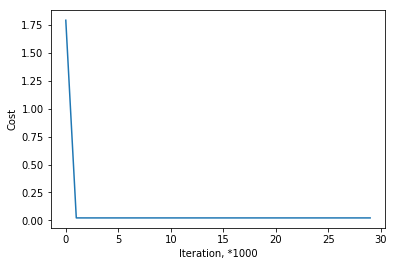

In [13]:
cls = SVD(n_factors=3)
cls.fit(table)

In [14]:
print(table)
print(table[1][0])
print(cls.estimate(1,0))

[[2, 1, 3, 1], [4, 1, 3, 4], [5, 5, 1, 1], [2, 1, 3, 2], [2, 2, 3, 1]]
4
3.9545943714257636


In [15]:
print(cls.accuracy())

(0.9990020952889679, 0.971622857934225, [2, 1, 3, 1, 4, 1, 3, 4, 5, 5, 1, 1, 2, 1, 3, 2, 2, 2, 3, 1], [1.9725440786358654, 1.038791840452463, 2.9606139422434925, 1.05214663966448, 3.9545943714257636, 1.040882443008473, 3.006042725281126, 3.9619924734448135, 4.9560430201094245, 4.957988460164864, 1.0320135734336342, 1.02308314302752, 2.030370046133882, 1.0102140838534284, 2.995910470986887, 1.9852833374544425, 2.0264381633827617, 1.9897315067351045, 2.9777540537854916, 1.0200158980638814])


In [ ]:
print(X[:100])

[[ 5.1   4.9   1.75 ... -0.19  3.25  4.37]
 [-8.79 -0.87  1.99 ...  4.13 -1.84  2.96]
 [-3.5  -2.91 -2.18 ... -6.89 -2.33 -7.38]
 ...
 [ 0.15  0.15  0.49 ... -0.29  5.29 -7.48]
 [ 4.61  5.34  6.5  ... -3.98 -0.78 -6.84]
 [ 6.8   4.32  8.64 ... -6.46  5.92  7.77]]


In [ ]:
factors = min(np.matrix(X).shape)
cls = SVD(eps = 0.01 , num_iter = 10000,n_factors=5,n_print=100)
cls.fit(X)

0-th iteration: -4.3595091935814425
100-th iteration: -3.5922262360064083
200-th iteration: -4.4648784871445235
300-th iteration: -3.091913051660028
400-th iteration: -2.082202932113859
500-th iteration: -4.450125773365389
600-th iteration: -4.359409095931836
700-th iteration: -4.570622353941168
800-th iteration: -1.6394049894496106
900-th iteration: -3.2000657848749205
1000-th iteration: -4.146185422537259
1100-th iteration: -3.845875599160617
1200-th iteration: -1.063077683073844
1300-th iteration: -3.2048436832152403
1400-th iteration: -2.9910719061532305
1500-th iteration: -4.514348409928749
1600-th iteration: -2.487763632262034
1700-th iteration: -1.834896686989087
1800-th iteration: -1.5603317774057204
1900-th iteration: -2.7754472176099814
2000-th iteration: -3.007293248055393
2100-th iteration: -3.6011410517476197
2200-th iteration: -4.170776592769439
2300-th iteration: -3.141593453201873
2400-th iteration: -3.8421658372623977
2500-th iteration: -4.0418049105049265
2600-th iter

In [ ]:
print(cls.accuracy()[0:2])